# Predição do Estado de uma Smart Grid

A proposta deste trabalho é desenvolver e aplicar métodos de regressão para prever o estado operacional de uma rede inteligente (Smart Grid).

# Domínio da Aplicação

Os dados utilizados representam simulações de uma rede elétrica inteligente (Smart Grid).

### Exploração da Base de Dados

Coletando os [dados simulados de estabilidade de uma rede elétrica](https://archive.ics.uci.edu/dataset/471/electrical+grid+stability+simulated+data)

In [4]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo 

electrical_grid_stability_simulated_data = fetch_ucirepo(id=471).data

features = electrical_grid_stability_simulated_data.features 
targets = electrical_grid_stability_simulated_data.targets

data = pd.merge(features, targets, left_index=True, right_index=True, how='outer')

### Explicando os Atributos

- tau[x]: Tempo de reação do participante (valor real no intervalo [0.5, 10] segundos). 
    - tau1 - o valor para o produtor de eletricidade;
- p[x]: Potência nominal consumida (negativa) ou produzida (positiva) (valor real). 
    - Para consumidores, no intervalo [-0.5, -2] segundos^-2;
    - p1 = abs(p2 + p3 + p4);
- g[x]: Coeficiente (gamma) proporcional à elasticidade de preço (valor real no intervalo [0.05, 1] segundos^-1). 
    - g1 - o valor para o produtor de eletricidade;
- stab: A parte real máxima da raiz da equação característica (se positiva - o sistema é linearmente instável) (valor real).
- stabf: A classificação de estabilidade do sistema (categórica: estável/instável).


### Visualização os Dados

In [5]:
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


# Pré-Processamento dos Dados

### Eliminação do dado discreto, `stabf`

Com o objetivo de prever o próximo estado da rede, a partir do valor contínuo `stab`, temos que eliminar o valor `stabf` já que depende de `stab`.

In [6]:
data.drop(columns=['stabf'], inplace=True)

### Análise das Correlações

Analisar as correlações das váriaveis para escolher as melhores váriaveis para os modelos de regressão.

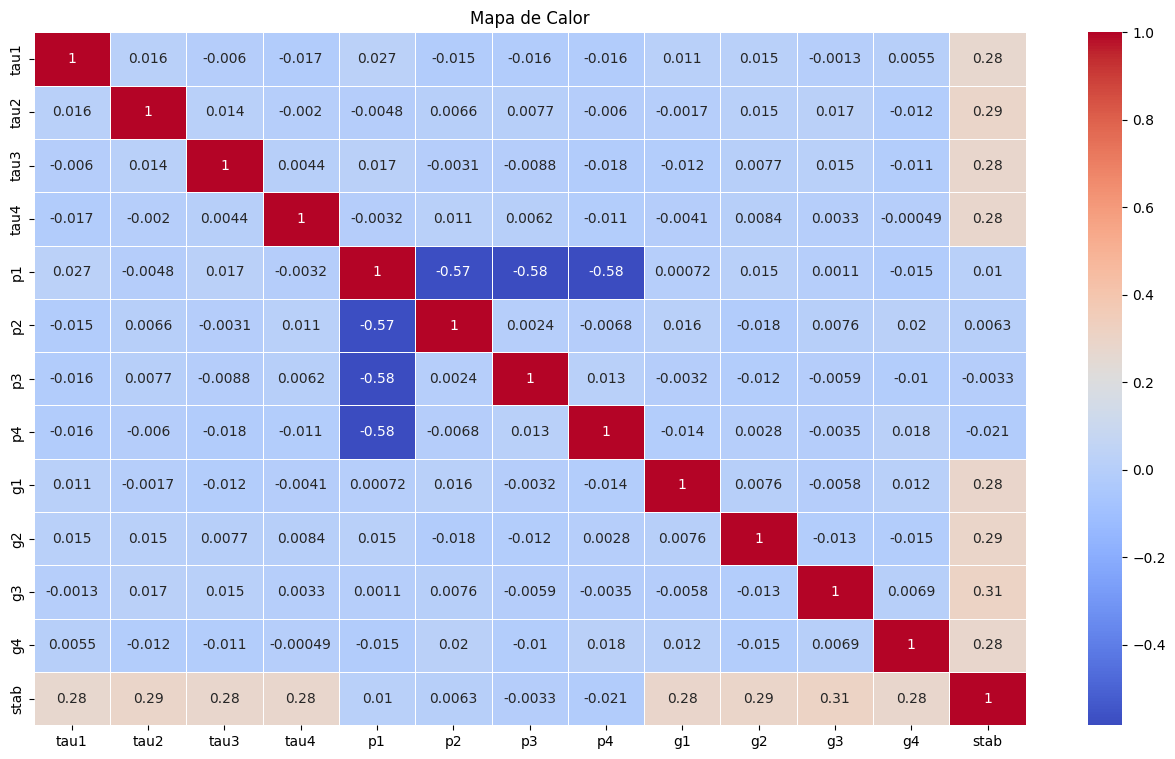

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt

correlation_matrix = data.corr()

plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor')
plt.show()

## Limpeza os dados

Vendo a baixa correlação das variáveis $p_x$ com $stab$, é decidido a remoção desses valores, para melhorar o aprendizado do modelo.

In [8]:
data.drop(columns=['p1', 'p2', 'p3', 'p4'], inplace=True)

# Reconhecimento de Padrões e Aprendizados

### Definição de Métodos e Classes de Apoio

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_data_structure():
    '''
    Cria um objeto com a estrutura de dados preparada para armazenar as informações durante os treinamentos.
    '''
    return {
        "r2": [],
        "mse": [],
        "mae": [],
        "pred": [],
        "test": [],
        "mape": [],
    }

def get_class_name(object):
    return object.__class__.__name__

class Fitter:
    '''
    Classe de apoio para facilitar no treinamento de cada modelo.
    '''
    def __init__(self, x_train, y_train, x_test, y_test) -> None:
        self.__x_train = x_train
        self.__y_train = y_train
        self.__x_test = x_test
        self.__y_test = y_test

    def fit_model_and_measure(self, model, data):
        model.fit(self.__x_train, self.__y_train)
        
        pred = model.predict(self.__x_test)

        data['pred'].append(pred)
        data['test'].append(self.__y_test)
        data['r2'].append(r2_score(self.__y_test, pred))
        data['mse'].append(mean_squared_error(self.__y_test, pred))
        data['mae'].append(mean_absolute_error(self.__y_test, pred))
        data['mape'].append(np.mean(np.abs((self.__y_test - pred) / self.__y_test)) * 100)

### Definição dos modelos a serem usados.

Exploração de vários modelos definidos pela literatura, para entender qual melhor resolve o problema.

In [10]:
from sklearn.svm import SVR, NuSVR
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet, BayesianRidge, ARDRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor


MODELS = [
    BayesianRidge(),
    ARDRegression(),
    Lasso(alpha=0.1),
    Ridge(alpha=1.0),
    LinearRegression(),
    SVR(kernel='linear', C=1.0),
    NuSVR(nu=0.5, kernel='rbf'),
    LGBMRegressor(max_depth=10, verbose=-1),
    KNeighborsRegressor(n_neighbors=5),
    ElasticNet(alpha=0.1, l1_ratio=0.5),
    AdaBoostRegressor(n_estimators=100),
    SGDRegressor(max_iter=1000, tol=1e-3),
    ExtraTreesRegressor(n_estimators=100),
    XGBRegressor(learning_rate=0.1, max_depth=8), 
    MLPRegressor(hidden_layer_sizes=(100,), max_iter=500),
    RandomForestRegressor(n_estimators=100, random_state=0),
    HistGradientBoostingRegressor(max_iter=100, learning_rate=0.1),
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
    DecisionTreeRegressor(max_depth=5, splitter='random', min_samples_leaf=5),
]

### Treinamento e Validação dos Primeiros Modelos

Treinamento dos 18 modelos escolhidos para verificar os melhores candidatos.

In [11]:
from tqdm import tqdm
from sklearn.model_selection import KFold

outputs = {}

for model in MODELS:
    outputs[get_class_name(model)] = create_data_structure()
 
five_folds = KFold(n_splits=5, random_state=0, shuffle=True)

STAB_COLUMN_INDEX = list(data.columns).index('stab')

number_of_operations = len(MODELS) * 5 

progress_bar = tqdm(total=number_of_operations)

y_data = data['stab'].values
x_data = data.drop(columns=['stab']).values

for index, (train_index, test_index) in enumerate(five_folds.split(data)):
    y_train = y_data[train_index]
    x_train = x_data[train_index]

    y_test = y_data[test_index]
    x_test = x_data[test_index]

    fitter = Fitter(
        x_train=x_train,
        x_test=x_test,
        y_train=y_train,
        y_test=y_test,
    )

    for model in MODELS:
        fitter.fit_model_and_measure(model, data=outputs[get_class_name(model)])
        progress_bar.update()

 99%|█████████▉| 94/95 [01:41<00:01,  1.68s/it]

### Definindo funções de apoio para visualização

In [12]:
def create_metrics(error_structure):
    metrics = {
        'MSE': error_structure['mse'], 
        'MAE': error_structure['mae'], 
        'MAPE': error_structure['mape'],
        'R2': error_structure['r2']
    }

    mean_std = {metric: (np.mean(scores), np.std(scores)) for metric, scores in metrics.items()}

    return mean_std

### Geração de Visibilidades dos Primeiros modelos

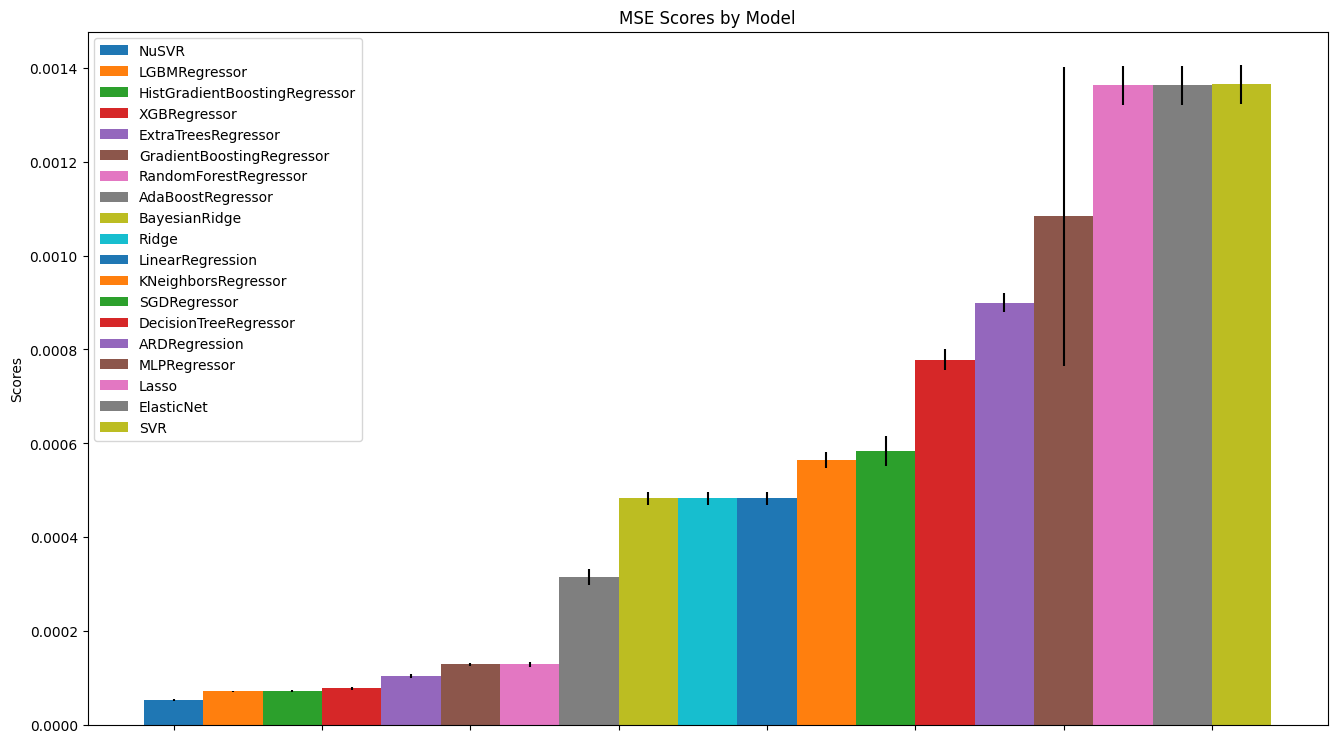

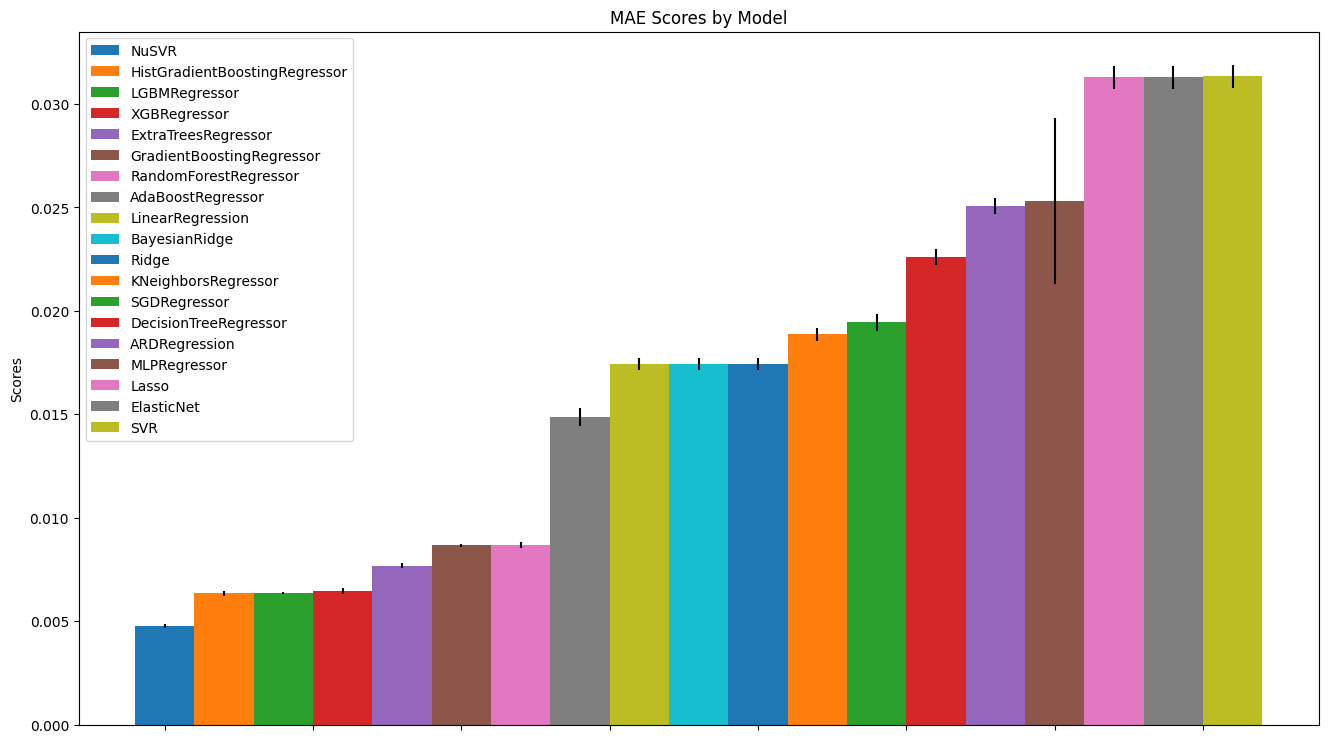

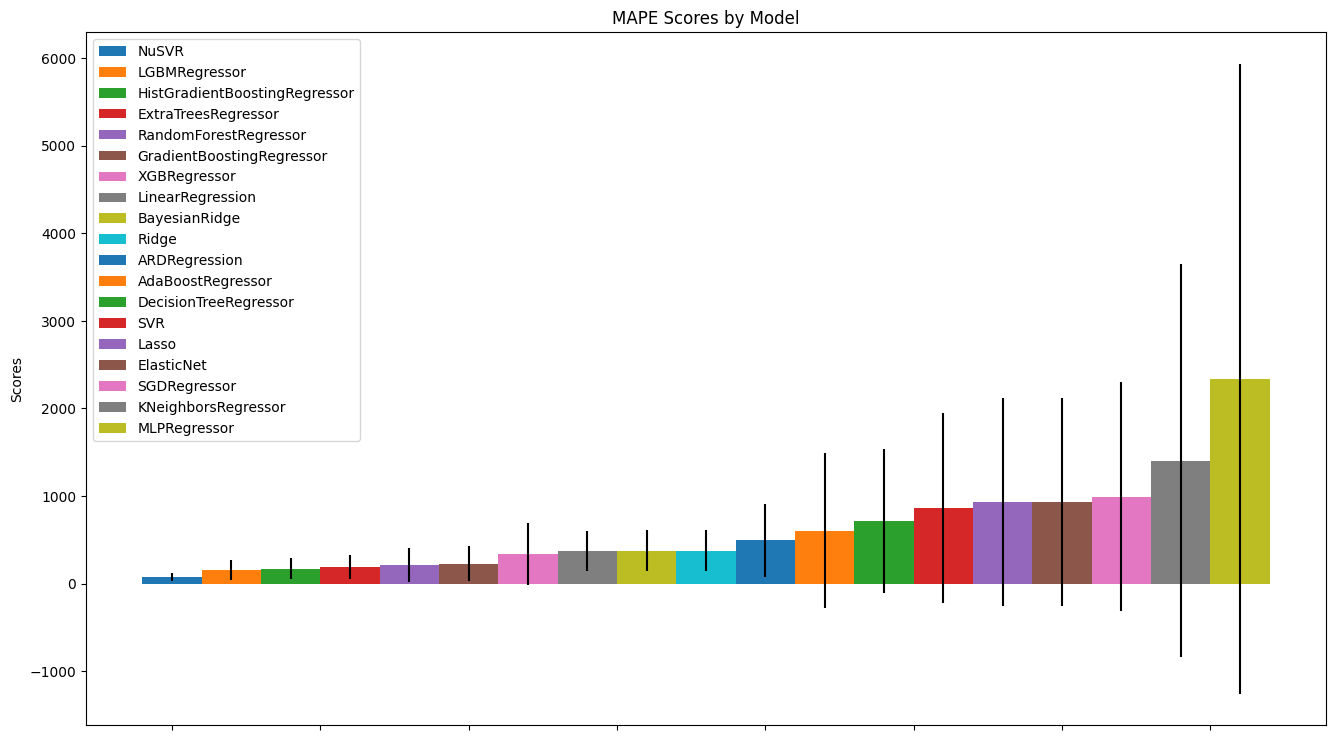

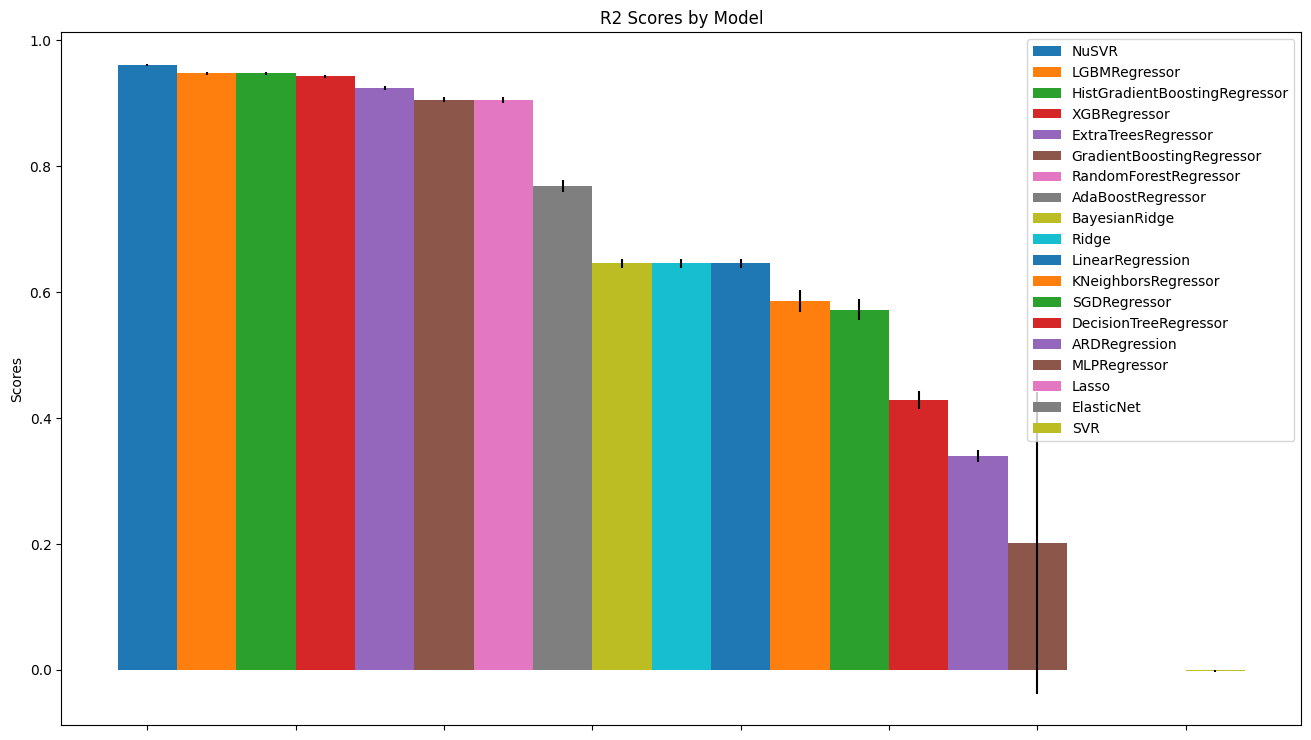

In [13]:
METRICS = ['MSE', 'MAE', 'MAPE', 'R2']

model_metrics = {}

for model in MODELS:
    model_metrics[get_class_name(model)] = create_metrics(outputs[get_class_name(model)])

# Função para plotar gráficos de métricas
def plot_metrics(metric_name, model_metrics:dict, reverse=False):
    width = 0.2

    fig, ax = plt.subplots(figsize=(16, 9))

    sorted_metrics = sorted(model_metrics.items(), key=lambda x:x[1][metric_name][0], reverse=reverse)

    for index, (model_name, metric_values) in enumerate(sorted_metrics):
        x_position = index * width

        height = metric_values[metric_name][0] 

        y_error = metric_values[metric_name][1]

        ax.bar(x_position, height, width, label=model_name, yerr=y_error)

    ax.set_ylabel('Scores')
    ax.set_title(f'{metric_name} Scores by Model')
    ax.set_xticklabels("")
    ax.legend()

    plt.show()

for metric in METRICS:
    plot_metrics(metric, model_metrics, metric == 'R2')

### Filtragem dos Modelos

A partir dessa primeira comparação, será escolhido três melhores modelos, considerando as visibilidades
- NuSVR
- LGBMRegressor
- HistGradientBoostingRegressor

E para cada modelo, aplicar o método de GridSearch para encontrar os melhores parâmetros para cada modelo.

In [14]:
BEST_MODELS = [
    (NuSVR(), {
        'nu': [0.1, 0.5, 0.9],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    }),
    (HistGradientBoostingRegressor(), {
        'learning_rate': [0.01, 0.1, 0.3],
        'max_iter': [100, 200, 300],        
        'max_depth': [None, 10, 20],
        'l2_regularization': [0.0, 0.1, 0.5]
    }), 
    (LGBMRegressor(), {
        'boosting_type': ['gbdt', 'dart', 'rf'],
        'max_depth': [5, 10, 20],
        'learning_rate': [0.01, 0.1, 0.3],
        'verbosity': [-1]
    })
]

### Treinamento e busca dos melhores modelos

In [27]:
from os import cpu_count
from IPython.display import clear_output
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split

number_of_cpus = cpu_count()

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

y_data = data['stab'].values
x_data = data.drop(columns=['stab']).values

fitter = Fitter(
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
)

best_outputs = {}

for model, _ in BEST_MODELS:
    best_outputs[get_class_name(model)] = create_data_structure()

for model, params in BEST_MODELS:
    model_name = get_class_name(model)

    grid_search = HalvingGridSearchCV(model, params, n_jobs=number_of_cpus, cv=2, scoring='r2') #['r2', 'neg_median_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']

    fitter.fit_model_and_measure(grid_search, data=best_outputs[get_class_name(model)])

    best_outputs[model_name]['best_params'] = grid_search.best_params_
    best_outputs[model_name]['best_model'] = grid_search.best_estimator_

clear_output()

### Visualização dos Resultados dos Três Modelos

In [32]:
METRICS = ['MSE', 'MAE', 'MAPE', 'R2']

model_metrics = {}

for model,_ in BEST_MODELS:
    model_name = get_class_name(model)

    try:
        print(best_outputs[model_name]['best_model'].predictors_)
    except:
        pass
    model_metrics[model_name] = create_metrics(best_outputs[model_name])

# Função para plotar gráficos de métricas
def plot_metrics(metric_name, model_metrics:dict, reverse=False):
    width = 0.2

    fig, ax = plt.subplots(figsize=(16, 9))

    sorted_metrics = sorted(model_metrics.items(), key=lambda x:x[1][metric_name][0], reverse=reverse)

    for index, (model_name, metric_values) in enumerate(sorted_metrics):
        x_position = index * width

        height = metric_values[metric_name][0] 

        y_error = metric_values[metric_name][1]

        ax.bar(x_position, height, width, label=model_name, yerr=y_error)

    ax.set_ylabel('Scores')
    ax.set_title(f'{metric_name} Scores by Model')
    ax.set_xticklabels("")
    ax.legend()

    plt.show()

for metric in METRICS:
    plot_metrics(metric, model_metrics, metric == 'R2')

_, ax = plt.subplots(figsize=(16, 9))

ax.plot(y_test[::30], label='True Value')
for model,params in BEST_MODELS:
    print(params)
    model_name = get_class_name(model)
    ax.plot(best_outputs[model_name]['pred'][0][::30], label=model_name, linestyle='--')

ax.set_title('True Values vs Predictions from Multiple Models')
ax.set_ylabel('Value')
ax.legend()
ax.grid(True)

AttributeError: 'NuSVR' object has no attribute 'predictors_'

## Discussão

Avaliando os Três modelos, é o modelo NuSVR está com um desempenho superior tanto ao LGBM como também ao HistGradientBoostingRegressor, todavia o NuSVR só alcança tais resultados quando há um uso de 90% do dados como Vetores de Suporte, dando indício de Overfitting, então a utilização de um índice de uso deverá ser menor para evitar o overfitting.
Enquanto isso o modelo LGBM apresenta....

## Conclusão

Responder à pergunta: "Você acredita que será possível entregar tudo que prometeu no documento da Proposta?"

Sim, por mais que esteja apenas no começo do projeto, já é possivel fazer algumas análises utilizando regressão linear e arvore de regressão como visto em aula, com o que já temos fica facil crial pipelines para os ajustes nos dados e também abre a possibilidade para random forests. Com o objetivo final de evitar overfitting e garantir também que seja possivel obter respostas e tomadas de decisões razoáveis em relação aos dados estabelecidos.

### Referências Bibliográficas

- Deng, Y., Cao, K. K., Hu, W., et al. (2023). "Harmonized and Open Energy Dataset for Modeling a Highly Renewable Brazilian Power System." *Scientific Data*, 10, 103. https://doi.org/10.1038/s41597-023-01992-9

- Brown, T., Hörsch, J., & Schlachtberger, D. (2018). "PyPSA: Python for Power System Analysis." *Journal of Open Research Software*, 6(1). arXiv:1707.09913. DOI:10.5334/jors.188

- SAP Insights. "The Smart Grid: How AI is Powering Today’s Energy Technologies." Disponível em: SAP Insights. Acesso em: 11 jul. 2024.

- Satu, Md & Khan, Md Imran. (2024). "Machine Learning Approaches To Predict The Stability of Smart Grid." https://doi.org/10.21203/rs.3.rs-3866218/v1

- Deng, Y. (2021). "PyPSA-Brazil: A Free and Open Model of the Brazilian Electrical System." *Energy Proceedings*.

- Zheng, X., Xu, N., Trinh, L., et al. (2022). "A multi-scale time-series dataset with benchmark for machine learning in decarbonized energy grids." *Scientific Data*, 9, 359. https://doi.org/10.1038/s41597-022-01455-7
